# DQN for MsPacman-V0

### Import libraries and select GPU

In [1]:
import gym
import gym.spaces
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from collections import namedtuple, deque
import itertools
import sys
import random
#SELECT GPU
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

#### Preprocess function from tutorial

In [2]:
mspacman_color = 210 + 164 + 74
def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80)


In [3]:
env = gym.envs.make("MsPacman-v0")


#### Sample image

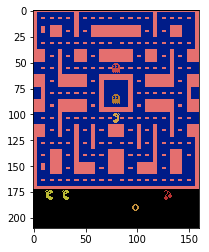

In [4]:
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

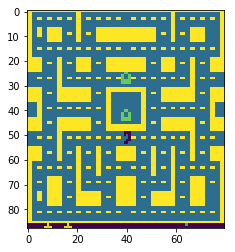

In [5]:
## Sample preprocessed image
test_obs = env.reset()
processed = preprocess_observation(test_obs)
plt.figure()
plt.imshow(processed)

In [6]:
env.action_space

Discrete(9)

In [7]:
env.action_space.contains(3)

True

In [8]:
# DEFINE ACTION SPACE
poss_actions = [0,1,2,3,4,5,6,7,8]

#### Basic Hyperparameters

In [9]:
#LEARNING RATE
learning_rate = 5e-4
q_scope = 'q'
target_scope = 'target_q'

## Helper functions for the model, policy, and target update

In [10]:
def build_model(scope):
        """
        Function to build a tensorflow graph and return its components
        """
        #This folder will store the summaries folder.
        summaries_dir = "./pacman_summaries"
        
        with tf.variable_scope(scope):
            # Placeholders for our input
        
            X_pl = tf.placeholder(shape=[None, 88, 80,4], dtype=tf.float32, name="X")
            # The TD target value
            y_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
            # Index of selected action
            actions_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")
            
            X = X_pl
            batch_size = tf.shape(X_pl)[0]
            
            # Three convolutional layers
            conv1 = tf.contrib.layers.conv2d(
                X, 32, 8, 2, activation_fn=tf.nn.relu)
            conv2 = tf.contrib.layers.conv2d(
                conv1, 64, 4, 2, activation_fn=tf.nn.relu)
            conv3 = tf.contrib.layers.conv2d(
                conv2, 64, 3, 1, activation_fn=tf.nn.relu)
            # Fully connected layers - 1 hiden layer and an output layer.
            flattened = tf.contrib.layers.flatten(conv3)
            fc1 = tf.contrib.layers.fully_connected(flattened, 512)
            predictions = tf.contrib.layers.fully_connected(fc1, len(poss_actions), activation_fn=None)
            # Get the predictions for the chosen actions only
#             gather_indices = tf.range(batch_size) * tf.shape(predictions)[1] + actions_pl
#             action_predictions = tf.gather(tf.reshape(predictions, [-1]), gather_indices)
            
            #Only take Q for the action we take (multiply with one hot vector)
            action_one_hot = tf.one_hot(actions_pl, len(poss_actions), 1.0, 0.0, name='action_one_hot')
            action_predictions = tf.reduce_sum(tf.multiply(predictions, action_one_hot), axis=1)
            
            # Calculate the loss
            losses = tf.squared_difference(y_pl, action_predictions)
            loss = tf.reduce_mean(losses)
            # Adam optimizer to reduce MSE
            optimizer = tf.train.AdamOptimizer(learning_rate)#, 0.99, 0.0, 1e-6)
            train_op = optimizer.minimize(loss, global_step=tf.contrib.framework.get_global_step())
            
            #Summaries for tensorboard
            summaries = tf.summary.merge([
            tf.summary.scalar("loss", loss),
            tf.summary.histogram("loss_hist", losses),
            tf.summary.histogram("q_values_hist", predictions),
            tf.summary.scalar("max_q_value", tf.reduce_max(predictions))
            ])
            
            #Create summary_dir when building the model
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                summary_writer = tf.summary.FileWriter(summary_dir)

        return predictions, train_op, X_pl, y_pl, actions_pl, summaries, summary_writer, loss


In [11]:
def copy_model_parameters(sess, estimator1_scope, estimator2_scope):
    """
    Copies the model parameters of one estimator to another.
    Args:
      sess: Tensorflow session instance
      estimator1_scope: Variables with this scope will be copied
      estimator2_scope: Variables with this scope will be updated
    """
    e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1_scope)]
    e1_params = sorted(e1_params, key=lambda v: v.name)
    e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2_scope)]
    e2_params = sorted(e2_params, key=lambda v: v.name)
    update_ops = []
    for e1_v, e2_v in zip(e1_params, e2_params):
        op = e2_v.assign(e1_v)
        update_ops.append(op)
    sess.run(update_ops)

In [12]:
def make_epsilon_greedy_policy(q_predictions, q_X, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    Args:
        q_predictions: The tf node that gets q predictions for each action given a state
        q_X: The tf node that is the input placeholder for the network (state)
        nA: Number of actions in the environment.
    Returns:
        A function that takes the (sess, observation, epsilon) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    """
    def policy_fn(sess, observation, epsilon):
        A = np.ones(nA, dtype=float) * epsilon / nA
        #q_values = estimator.predict(sess, np.expand_dims(observation, 0))[0]
        #Get q values for the various actions
        q_values = sess.run(q_predictions, feed_dict={q_X : np.expand_dims(observation,0)})[0]
        best_action = np.argmax(q_values)
        #Use the linearly decreasing explore factor for the suboptimal actions, and 1-epsilon for optimal
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

## DQN Function where network is trained and epsilon greedy policy updated

In [13]:
def deep_q_learning(sess,
                    env,
                    q_estimator,
                    target_estimator,
                    num_episodes,
                    experiment_dir,
                    replay_memory_size=800000,
                    replay_memory_init_size=50000,
                    update_target_estimator_every=8000,
                    discount_factor=0.99,
                    epsilon_start=1.0,
                    epsilon_end=0.05,
                    epsilon_decay_steps=650000,
                    batch_size=32):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    Args:
        sess: Tensorflow Session object
        env: OpenAI environment
        q_estimator: tuple containing relevant nodes for the q-network
        target_estimator: tuple containing relevant nodes for the target network
        num_episodes: Number of episodes to train for
        experiment_dir: Directory to save Tensorflow summaries in
        replay_memory_size: Size of the replay memory (max number of steps)
        replay_memory_init_size: Number of random experiences to sample when initializing 
          the replay memory.
        update_target_estimator_every: Copy parameters from the Q estimator to the 
          target estimator every _ steps.
        discount_factor: Lambda time discount factor (Provided for HW)
        epsilon_start: Chance to sample a random action when taking an action.
          Epsilon is decayed over time and this is the start value
        epsilon_end: The final minimum value of epsilon after decaying is done
        epsilon_decay_steps: Number of steps to decay epsilon over
        batch_size: Size of batches to sample from the replay memory
        
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    #Store the graph nodes as variables
    q_predictions, q_train_op, q_X, q_y, q_actions, q_summaries, q_summary_writer, q_loss = q_estimator
    target_predictions, target_train_op, target_X, target_y, target_actions,\
    target_summaries, t_summary_writer, target_loss = target_estimator
    #Transitions that will be stored in replay memory
    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    # The replay memory
    replay_memory = []
    
    # Keeps track of useful statistics
    tot_episode_rewards = []
    tot_episode_lengths = []
    
    # Create directories for checkpoints and summaries
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
    
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
 
    saver = tf.train.Saver()
    
    # Load a previous checkpoint if we find one
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)
    
    # Get the current time step
    total_t = sess.run(tf.contrib.framework.get_global_step())
    
    # The epsilon decay schedule - LINEARLY DECREASING STEP BY STEP
    epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)
    
    # The Policy Function
    policy = make_epsilon_greedy_policy(
        q_predictions, q_X,
        len(poss_actions))
    
    # Populate the replay memory with initial experience with existing policy and network
    print("Populating replay memory...")
    state = env.reset()
    state = preprocess_observation(state)
    
    #WE STACK THE PAST 4 FRAMES AS THE STATE INPUT, and therefore copies of the first state for a new game.
    state = np.stack([state] * 4, axis=2)
    for i in range(replay_memory_init_size):
        action_probs = policy(sess, state, epsilons[min(total_t, epsilon_decay_steps-1)])
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        next_state, reward, done, _ = env.step(poss_actions[action])
        next_state = preprocess_observation(next_state)
        #Move the 4 frames forward in time.
        next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)
        replay_memory.append(Transition(state, action, reward, next_state, done))
        if done:
            state = env.reset()
            state = preprocess_observation(state)
            state = np.stack([state] * 4, axis=2)
        else:
            state = next_state
    
    for i_episode in range(num_episodes):
        tot_episode_rewards.append(0)
        tot_episode_lengths.append(0)
        q_predictions, q_train_op, q_X, q_y, q_actions, q_summaries, q_summary_writer, q_loss = q_estimator
        target_predictions, target_train_op, target_X, target_y, target_actions,\
        target_summaries, t_summary_writer, target_loss = target_estimator
        
        # Save the current checkpoint
        saver.save(tf.get_default_session(), checkpoint_path)
        
        # Reset the environment
        state = env.reset()
        state = preprocess_observation(state)
        #Stack the initial frame 4 times initially.
        state = np.stack([state] * 4, axis=2)
        loss = None
        
        # One step in the environment
        for t in itertools.count():
            
            # Epsilon for this time step
            epsilon = epsilons[min(total_t, epsilon_decay_steps-1)]
            
            # Add epsilon to Tensorboard
            episode_summary = tf.Summary()
            episode_summary.value.add(simple_value=epsilon, tag="epsilon")
            q_summary_writer.add_summary(episode_summary, total_t)
            
            # Update the target network every N steps
            if total_t % update_target_estimator_every == 0:
                copy_model_parameters(sess, q_scope, target_scope)
                print("\nCopied model parameters to target network.")
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} ({}) @ Episode {}/{}, loss: {}".format(
                    t, total_t, i_episode + 1, num_episodes, loss), end="")
            
            sys.stdout.flush()
            
            # Take a step
            #Get action probabilities for the current state
            action_probs = policy(sess, state, epsilon)
            #Pick an action using this probability distribution
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            #Get next state by stepping through env.
            next_state, reward, done, _ = env.step(poss_actions[action])
            next_state = preprocess_observation(next_state)
            #Stack new frame and pop out fourth frame.
            next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)
            
            # If our replay memory is full, pop the first element
            if len(replay_memory) == replay_memory_size:
                replay_memory.pop(0)
            # Save transition to replay memory
            replay_memory.append(Transition(state, action, reward, next_state, done))   
            # Update statistics
            tot_episode_rewards[i_episode] += reward
            tot_episode_lengths[i_episode] = t
            
            # Sample a minibatch from the replay memory
            samples = random.sample(replay_memory, batch_size)
            states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))
            
            # Calculate q values and targets using the TARGET NETWORK!
          
            q_values_next = sess.run(target_predictions, feed_dict= {target_X: next_states_batch})
            targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * discount_factor * np.amax(q_values_next, axis=1)
            
            # Perform gradient descent update for Q network
            states_batch = np.array(states_batch)

            feed_dict = { q_X: states_batch, q_y: targets_batch, q_actions: action_batch }
            summaries, global_step, _, loss = sess.run(
                [q_summaries, tf.contrib.framework.get_global_step(), q_train_op, q_loss],
            feed_dict)
            
            #Write summaries
            q_summary_writer.add_summary(summaries, global_step)
            
            if done:
                break
            state = next_state
            total_t += 1
        # Add summaries to tensorboard and flush after writing
        episode_summary = tf.Summary()
        episode_summary.value.add(simple_value=tot_episode_rewards[i_episode], node_name="episode_reward", tag="episode_reward")
        episode_summary.value.add(simple_value=tot_episode_lengths[i_episode], node_name="episode_length", tag="episode_length")
        q_summary_writer.add_summary(episode_summary, total_t)
        q_summary_writer.flush()


## Main Function to run the script

In [14]:
tf.reset_default_graph()
# Where we save our checkpoints and graphs
experiment_dir = os.path.relpath("./pacman_experiments")
# Create a global step variable for training iteration count
global_step = tf.Variable(0, name='global_step', trainable=False)
    
# Create graphs for Q and target networks and store nodes in tuples
q_estimator = build_model(scope="q")
target_estimator = build_model(scope="target_q")

# Run it!
with tf.Session() as sess:
    #Initialize graphs
    sess.run(tf.global_variables_initializer())

    #RUN DQN
    deep_q_learning(sess,
                    env,
                    q_estimator=q_estimator,
                    target_estimator=target_estimator,
                    experiment_dir=experiment_dir,
                    num_episodes=50000,
                    replay_memory_size=800000,
                    replay_memory_init_size=50000,
                    update_target_estimator_every=8000,
                    epsilon_start=1.0,
                    epsilon_end=0.1,
                    epsilon_decay_steps=500000,
                    discount_factor=0.95,
                    batch_size=32)


Instructions for updating:
Please switch to tf.train.get_global_step
Populating replay memory...

Copied model parameters to target network.
Step 600 (7999) @ Episode 12/50000, loss: 0.74198460578918465
Copied model parameters to target network.
Step 513 (15999) @ Episode 25/50000, loss: 1.34524059295654355
Copied model parameters to target network.
Step 138 (23999) @ Episode 39/50000, loss: 5.80030822753906254
Copied model parameters to target network.
Step 12 (31999) @ Episode 52/50000, loss: 2.789256572723388793
Copied model parameters to target network.
Step 465 (39999) @ Episode 63/50000, loss: 6.27528667449951264
Copied model parameters to target network.
Step 147 (47999) @ Episode 76/50000, loss: 1.58949255943298344
Copied model parameters to target network.
Step 265 (55999) @ Episode 87/50000, loss: 0.68997997045516976
Copied model parameters to target network.
Step 181 (63999) @ Episode 101/50000, loss: 2.5436687469482425
Copied model parameters to target network.
Step 354 (71

Step 724 (591999) @ Episode 840/50000, loss: 82.411300659179696
Copied model parameters to target network.
Step 402 (599999) @ Episode 851/50000, loss: 47.983459472656256
Copied model parameters to target network.
Step 579 (607999) @ Episode 862/50000, loss: 45.943675994873057
Copied model parameters to target network.
Step 677 (615999) @ Episode 872/50000, loss: 29.5261077880859385
Copied model parameters to target network.
Step 251 (623999) @ Episode 884/50000, loss: 65.6567230224609445
Copied model parameters to target network.
Step 418 (631999) @ Episode 897/50000, loss: 28.686817169189453
Copied model parameters to target network.
Step 539 (639999) @ Episode 908/50000, loss: 113.424812316894537
Copied model parameters to target network.
Step 42 (647999) @ Episode 920/50000, loss: 32.2941322326660165
Copied model parameters to target network.
Step 124 (655999) @ Episode 930/50000, loss: 59.1612129211425843
Copied model parameters to target network.
Step 508 (663999) @ Episode 942/5

Step 169 (1191999) @ Episode 1652/50000, loss: 23.925926208496094
Copied model parameters to target network.
Step 684 (1199999) @ Episode 1664/50000, loss: 7.0282115936279344
Copied model parameters to target network.
Step 43 (1207999) @ Episode 1674/50000, loss: 23.74544906616211537
Copied model parameters to target network.
Step 305 (1215999) @ Episode 1687/50000, loss: 22.223644256591797
Copied model parameters to target network.
Step 541 (1223999) @ Episode 1699/50000, loss: 22.9855804443359386
Copied model parameters to target network.
Step 1064 (1231999) @ Episode 1707/50000, loss: 44.779022216796875
Copied model parameters to target network.
Step 579 (1239999) @ Episode 1718/50000, loss: 13.2573633193969736
Copied model parameters to target network.
Step 435 (1247999) @ Episode 1731/50000, loss: 14.126269340515137
Copied model parameters to target network.
Step 134 (1255999) @ Episode 1741/50000, loss: 17.0718555450439454
Copied model parameters to target network.
Step 338 (1263

Step 142 (1791999) @ Episode 2469/50000, loss: 26.6967906951904336
Copied model parameters to target network.
Step 490 (1799999) @ Episode 2479/50000, loss: 21.2259063720703128
Copied model parameters to target network.
Step 647 (1807999) @ Episode 2490/50000, loss: 19.6847972869873052
Copied model parameters to target network.
Step 333 (1815999) @ Episode 2502/50000, loss: 7.95165348052978576
Copied model parameters to target network.
Step 601 (1823999) @ Episode 2514/50000, loss: 10.755113601684574
Copied model parameters to target network.
Step 506 (1831999) @ Episode 2524/50000, loss: 59.9004478454589849
Copied model parameters to target network.
Step 326 (1839999) @ Episode 2536/50000, loss: 23.599872589111328
Copied model parameters to target network.
Step 585 (1847999) @ Episode 2547/50000, loss: 61.799365997314457
Copied model parameters to target network.
Step 478 (1855999) @ Episode 2558/50000, loss: 60.1415786743164063
Copied model parameters to target network.
Step 328 (186

Step 461 (2391999) @ Episode 3291/50000, loss: 62.4923095703125845
Copied model parameters to target network.
Step 306 (2399999) @ Episode 3303/50000, loss: 11.7030544281005866
Copied model parameters to target network.
Step 112 (2407999) @ Episode 3314/50000, loss: 91.239967346191467
Copied model parameters to target network.
Step 141 (2415999) @ Episode 3324/50000, loss: 43.7927665710449274
Copied model parameters to target network.
Step 215 (2423999) @ Episode 3336/50000, loss: 203.81672668457035
Copied model parameters to target network.
Step 616 (2431999) @ Episode 3347/50000, loss: 29.4687194824218755
Copied model parameters to target network.
Step 212 (2439999) @ Episode 3360/50000, loss: 13.515980720520026
Copied model parameters to target network.
Step 591 (2447999) @ Episode 3372/50000, loss: 22.5307006835937553
Copied model parameters to target network.
Step 364 (2455999) @ Episode 3384/50000, loss: 46.8363952636718755
Copied model parameters to target network.
Step 417 (246

Step 700 (2991999) @ Episode 4139/50000, loss: 102.085037231445311
Copied model parameters to target network.
Step 129 (2999999) @ Episode 4151/50000, loss: 244.277954101562552
Copied model parameters to target network.
Step 112 (3007999) @ Episode 4162/50000, loss: 108.74522399902344
Copied model parameters to target network.
Step 290 (3015999) @ Episode 4174/50000, loss: 71.9886627197265625
Copied model parameters to target network.
Step 432 (3023999) @ Episode 4185/50000, loss: 46.7883262634277346
Copied model parameters to target network.
Step 686 (3031999) @ Episode 4194/50000, loss: 25.4488868713378922
Copied model parameters to target network.
Step 106 (3039999) @ Episode 4206/50000, loss: 58.232036590576174
Copied model parameters to target network.
Step 771 (3047999) @ Episode 4215/50000, loss: 44.5903968811035166
Copied model parameters to target network.
Step 65 (3055999) @ Episode 4226/50000, loss: 42.03705978393555668
Copied model parameters to target network.
Step 696 (30

Step 403 (3583999) @ Episode 4950/50000, loss: 76.4401397705078142
Copied model parameters to target network.
Step 36 (3591999) @ Episode 4960/50000, loss: 79.30052185058594183
Copied model parameters to target network.
Step 303 (3599999) @ Episode 4971/50000, loss: 50.6231689453125384
Copied model parameters to target network.
Step 386 (3607999) @ Episode 4983/50000, loss: 60.820343017578125
Copied model parameters to target network.
Step 115 (3615999) @ Episode 4993/50000, loss: 52.3881072998046954
Copied model parameters to target network.
Step 72 (3623999) @ Episode 5004/50000, loss: 190.8534545898437576
Copied model parameters to target network.
Step 222 (3631999) @ Episode 5014/50000, loss: 166.517150878906256
Copied model parameters to target network.
Step 496 (3639999) @ Episode 5023/50000, loss: 105.758941650390625
Copied model parameters to target network.
Step 14 (3647999) @ Episode 5033/50000, loss: 41.40034484863281856
Copied model parameters to target network.
Step 647 (3

Step 866 (4183999) @ Episode 5778/50000, loss: 122.75431060791016
Copied model parameters to target network.
Step 355 (4191999) @ Episode 5791/50000, loss: 424.72796630859375
Copied model parameters to target network.
Step 184 (4199999) @ Episode 5803/50000, loss: 162.943893432617262
Copied model parameters to target network.
Step 144 (4207999) @ Episode 5815/50000, loss: 128.318176269531255
Copied model parameters to target network.
Step 244 (4215999) @ Episode 5827/50000, loss: 50.656917572021484
Copied model parameters to target network.
Step 142 (4223999) @ Episode 5838/50000, loss: 2882.27124023437557
Copied model parameters to target network.
Step 376 (4231999) @ Episode 5849/50000, loss: 186.19895935058594
Copied model parameters to target network.
Step 341 (4239999) @ Episode 5860/50000, loss: 52.1517715454101568
Copied model parameters to target network.
Step 475 (4247999) @ Episode 5870/50000, loss: 126.059539794921882
Copied model parameters to target network.
Step 108 (4255

Step 319 (4775999) @ Episode 6571/50000, loss: 244.249145507812553
Copied model parameters to target network.
Step 373 (4783999) @ Episode 6582/50000, loss: 492.71856689453125
Copied model parameters to target network.
Step 173 (4791999) @ Episode 6593/50000, loss: 31.3007259368896566
Copied model parameters to target network.
Step 165 (4799999) @ Episode 6605/50000, loss: 223.37942504882812
Copied model parameters to target network.
Step 163 (4807999) @ Episode 6617/50000, loss: 181.21723937988289
Copied model parameters to target network.
Step 103 (4815999) @ Episode 6627/50000, loss: 153.280212402343755
Copied model parameters to target network.
Step 629 (4823999) @ Episode 6640/50000, loss: 55.994235992431642
Copied model parameters to target network.
Step 153 (4831802) @ Episode 6650/50000, loss: 396.873443603515655

KeyboardInterrupt: 